<a href="https://colab.research.google.com/github/berthe06/TP2MGL870/blob/main/TP_MGL_870_BGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from google.colab import drive

In [42]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Partie 1 : Parsing du fichier BGL.log**

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import IsolationForest
from logparser.Drain import Drain

# Initialisation du parseur Drain
parser = Drain.LogParser(
    log_format="<Label> <Timestamp> <Date> <Node> <Time> <NodeRepeat> <Type> <Component> <Level> <Content>",
    indir= r"/content/drive/MyDrive/tp2logs",
    outdir=r"/content/drive/MyDrive/tp2logs/BGL.log_structured.csv",
    depth=4,
    st=0.5,
    maxChild=100
)

ModuleNotFoundError: No module named 'logparser'

# **Partie 2: Exploration du jeux donnees**

In [2]:
## Importation des bibliothèques générales que nous utiliserons dans ce notebook
import numpy as np # algèbre linéaire
import pandas as pd # traitement des données, I/O de fichier CSV (par ex. pd.read_csv)
import seaborn as sns # bibliothèque de tracé qui utilise matplot
import matplotlib.pyplot as plt # pour tracer certains paramètres dans seaborn
from sklearn.neighbors import KNeighborsClassifier

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/tp2logs/BGL.log_structured.csv')

In [4]:
dataset.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
1,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
2,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
3,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
4,5,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]


In [5]:
# Afin de faciliter l'accès aux colonnes et d'éviter les erreurs, on remplace les espaces par des underscores (_) dans les noms de colonnes.
dataset.columns = [x.replace(' ', '_') for x in dataset.columns]

In [6]:
# Combien de données avons-nous?
print(f'Nous avons {dataset.shape[0]} lignes et {dataset.shape[1]} colonnes.')

Nous avons 4713493 lignes et 14 colonnes.


**Quels sont les types de caractéristiques (numériques vs catégorielles) ?**

In [7]:
# Quels sont les types de caractéristiques (numériques vs catégorielles) ?

print(dataset.dtypes)

LineId            int64
Label            object
Timestamp         int64
Date             object
Node             object
Time             object
NodeRepeat       object
Type             object
Component        object
Level            object
Content          object
EventId          object
EventTemplate    object
ParameterList    object
dtype: object


**Avons-nous des données manquantes?**

In [8]:
# Avons-nous des données manquantes?
missing_values = dataset.isnull().sum()
print(missing_values)

LineId                0
Label                 0
Timestamp             0
Date                  0
Node              89296
Time                  0
NodeRepeat        89296
Type             104215
Component             0
Level                 0
Content               0
EventId               0
EventTemplate         0
ParameterList         0
dtype: int64


# **Créer un dataframe séparé pour les variables Categoriel.**

In [9]:
# Créer un dataframe séparé pour les variables Categoriel.

logs_cat = dataset.select_dtypes(include=['object'])
logs_cat

,Label,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
1,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
2,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
3,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
4,-,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
4713488,KERNSOCK,2006.01.04,R00-M0-NC-I:J18-U11,2006-01-04-08.00.05.167045,R00-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]
4713489,KERNSOCK,2006.01.04,R36-M0-NC-I:J18-U11,2006-01-04-08.00.05.185942,R36-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]
4713490,KERNSOCK,2006.01.04,R30-M0-NC-I:J18-U11,2006-01-04-08.00.05.186013,R30-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]
4713491,KERNSOCK,2006.01.04,R31-M0-NC-I:J18-U11,2006-01-04-08.00.05.204230,R31-M0-NC-I:J18-U11,RAS,KERNEL,FATAL,idoproxy communication failure: socket closed,d7623fbd,idoproxy communication failure: socket closed,[]


In [10]:
# Quelle est la distribution de la variable `Label`?

print(dataset['Label'].value_counts())

-            4365033
KERNDTLB      152734
KERNSTOR       63491
APPSEV         49651
KERNMNTF       31531
KERNTERM       23338
KERNREC         6145
APPREAD         5983
KERNRTSP        3983
APPRES          2370
APPUNAV         2048
APPTO           1991
KERNMICRO       1503
APPOUT           816
KERNMNT          720
APPBUSY          512
KERNMC           342
APPCHILD         320
KERNSOCK         209
KERNPOW          192
LINKIAP          166
APPALLOC         144
KERNSERV          94
MASABNORM         37
LINKDISC          24
KERNPAN           18
KERNCON           16
KERNNOETH         14
LINKPAP           14
MONPOW            12
MASNORM           10
APPTORUS          10
KERNPROG           5
MMCS               3
KERNFLOAT          3
KERNRTSA           3
LINKBLL            2
MONNULL            2
KERNBIT            1
MONILL             1
KERNEXT            1
KERNTLBE           1
Name: Label, dtype: int64


# **Encoder les variables categorielles**

In [11]:
# Encoder les variables categorielles

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


for i in logs_cat.columns:
   # Conversion des catégories en valeurs numériques
    dataset[i] =  le.fit_transform(dataset[i])

# **Imputation simple (remplacer les valeurs manquantes par la médiane)**
# imputer = SimpleImputer(strategy='median')

In [12]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Imputation simple (remplacer les valeurs manquantes par la médiane)
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputation sur les colonnes avec des valeurs manquantes
dataset['Node'] = imputer.fit_transform(dataset[['Node']])
dataset['NodeRepeat'] = imputer.fit_transform(dataset[['NodeRepeat']])
dataset['Type'] = imputer.fit_transform(dataset[['Type']])

# Vérifier les résultats
print(dataset.isnull().sum())


LineId           0
Label            0
Timestamp        0
Date             0
Node             0
Time             0
NodeRepeat       0
Type             0
Component        0
Level            0
Content          0
EventId          0
EventTemplate    0
ParameterList    0
dtype: int64


**Exemple avec K-Nearest Neighbors Imputer**

In [13]:
from sklearn.impute import KNNImputer

# Utilisation de KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Appliquer l'imputation KNN sur les colonnes avec des valeurs manquantes
dataset[['Node', 'NodeRepeat', 'Type']] = knn_imputer.fit_transform(dataset[['Node', 'NodeRepeat', 'Type']])

# Vérifier les résultats
print(dataset.isnull().sum())


LineId           0
Label            0
Timestamp        0
Date             0
Node             0
Time             0
NodeRepeat       0
Type             0
Component        0
Level            0
Content          0
EventId          0
EventTemplate    0
ParameterList    0
dtype: int64


In [14]:
dataset.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1,0,1117838570,0,2739.0,0,2742.0,3.0,7,4,352408,432,1427,355694
1,2,0,1117838570,0,2739.0,1,2742.0,3.0,7,4,352408,432,1427,355694
2,3,0,1117838570,0,2739.0,2,2742.0,3.0,7,4,352408,432,1427,355694
3,4,0,1117838570,0,2739.0,3,2742.0,3.0,7,4,352408,432,1427,355694
4,5,0,1117838570,0,2739.0,4,2742.0,3.0,7,4,352408,432,1427,355694


In [15]:
# Quels sont les types de caractéristiques (numériques vs catégorielles) ?

print(dataset.dtypes)

LineId             int64
Label              int64
Timestamp          int64
Date               int64
Node             float64
Time               int64
NodeRepeat       float64
Type             float64
Component          int64
Level              int64
Content            int64
EventId            int64
EventTemplate      int64
ParameterList      int64
dtype: object


In [16]:

# Encoder les valeurs: remplacer toute valeur différente de 0 par 1
dataset['Label']= dataset['Label'].apply(lambda x: 1 if x != 0 else 0)

# Afficher les valeurs encodées
print("\nValeurs encodées:")
print(dataset['Label'])



Valeurs encodées:
0          0
1          0
2          0
3          0
4          0
          ..
4713488    1
4713489    1
4713490    1
4713491    1
4713492    1
Name: Label, Length: 4713493, dtype: int64


In [17]:
# Quelle est la distribution de la variable `Label`?

print(dataset['Label'].value_counts())

0    4365033
1     348460
Name: Label, dtype: int64


In [18]:
dataset.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1,0,1117838570,0,2739.0,0,2742.0,3.0,7,4,352408,432,1427,355694
1,2,0,1117838570,0,2739.0,1,2742.0,3.0,7,4,352408,432,1427,355694
2,3,0,1117838570,0,2739.0,2,2742.0,3.0,7,4,352408,432,1427,355694
3,4,0,1117838570,0,2739.0,3,2742.0,3.0,7,4,352408,432,1427,355694
4,5,0,1117838570,0,2739.0,4,2742.0,3.0,7,4,352408,432,1427,355694


In [19]:
# Créer un dataframe séparé pour les variables continues.
dataset_ready=dataset
data_num = dataset_ready.select_dtypes(include=['float64'])
data_num

,Node,NodeRepeat,Type
0,2739.0,2742.0,3.0
1,2739.0,2742.0,3.0
2,2739.0,2742.0,3.0
3,2739.0,2742.0,3.0
4,2739.0,2742.0,3.0
...,...,...,...
4713488,442.0,445.0,3.0
4713489,32918.0,32921.0,3.0
4713490,26432.0,26435.0,3.0
4713491,27513.0,27516.0,3.0


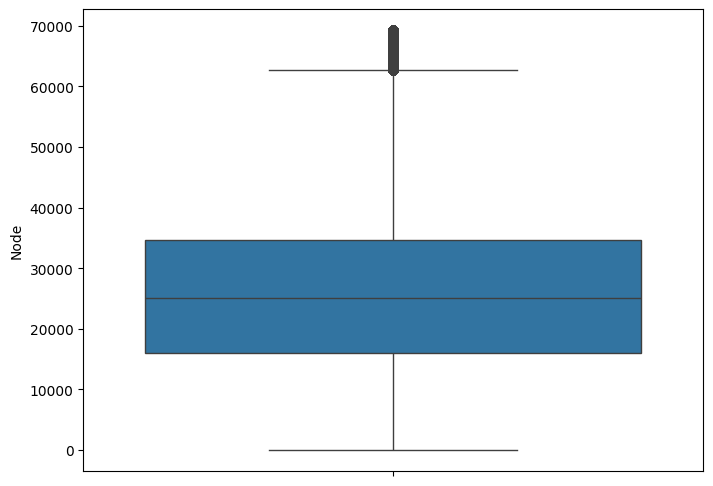

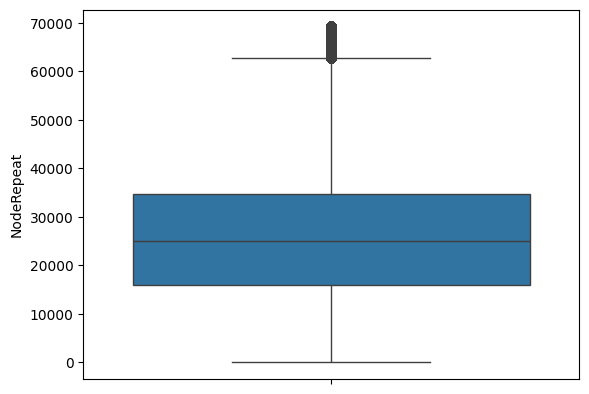

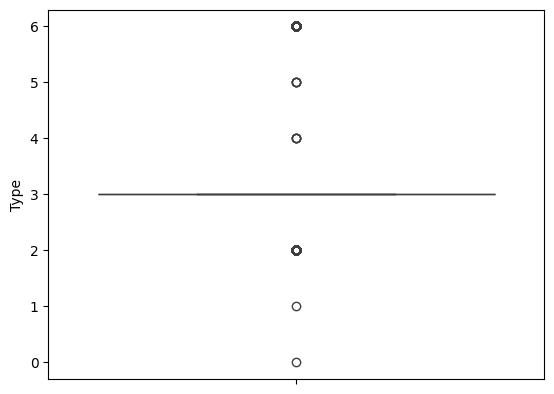

In [20]:
#Visualisation des valeurs aberrantes pour les variables continue avec BoxPlot
plt.figure(figsize = (8, 6))

for i in data_num.columns:
    sns.boxplot(dataset_ready[i])
    plt.show()

# **Affichage de la corrélation entre les variables numériques à l'aide d'une carte thermique**

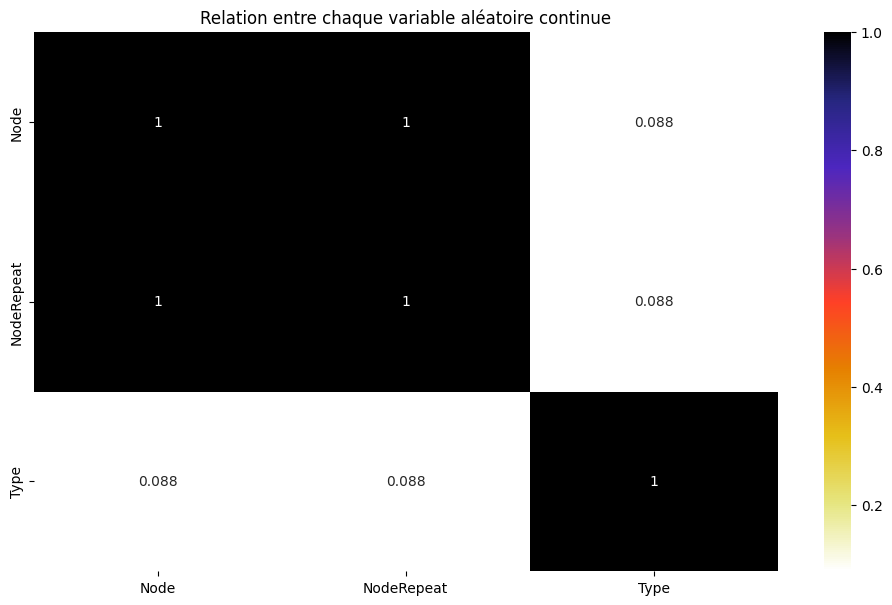

In [21]:
# Affichage de la corrélation entre les variables numériques à l'aide d'une carte thermique

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
cor = data_num.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.title('Relation entre chaque variable aléatoire continue')
plt.show()

Remarque : À partir du graphique ci-dessus, nous pouvons observer que les variables Node et NodeRepeat ont une forte corrélation entre elles et que les variables Type et Node , NodeRepeat ont une relation faible entre elles,

# **Traitement des valeurs aberantes**

In [22]:
dataset_ready[['Node', 'NodeRepeat', 'Type']].describe()

,Node,NodeRepeat,Type
count,4.713493e+06,4.713493e+06,4.713493e+06
mean,2.835028e+04,2.835795e+04,3.066266e+00
std,1.817757e+04,1.817930e+04,4.412143e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.601900e+04,1.602700e+04,3.000000e+00
50%,2.510300e+04,2.510800e+04,3.000000e+00
75%,3.467800e+04,3.468200e+04,3.000000e+00
max,6.925100e+04,6.925700e+04,6.000000e+00


In [23]:
# Traitement des valeurs aberrantes pour Node

Q1 = dataset_ready['Node'].quantile(0.25)
Q3 = dataset_ready['Node'].quantile(0.75)

IQR = Q3 - Q1
dataset_ready = dataset_ready[(dataset_ready['Node'] >= Q1 - 1.5*IQR) & (dataset_ready['Node'] <= Q3 + 1.5*IQR)]

In [24]:
# Traitement des valeurs aberrantes pour NodeRepeat

Q1 = dataset_ready['NodeRepeat'].quantile(0.25)
Q3 = dataset_ready['NodeRepeat'].quantile(0.75)

IQR = Q3 - Q1
dataset_ready = dataset_ready[(dataset['NodeRepeat'] >= Q1 - 1.5*IQR) & (dataset_ready['NodeRepeat'] <= Q3 + 1.5*IQR)]

<ipython-input-24-c6b1bcb1d0f1>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset_ready = dataset_ready[(dataset['NodeRepeat'] >= Q1 - 1.5*IQR) & (dataset_ready['NodeRepeat'] <= Q3 + 1.5*IQR)]


In [25]:
# Traitement des valeurs aberrantes pour Type

Q1 = dataset_ready['Type'].quantile(0.25)
Q3 = dataset_ready['Type'].quantile(0.75)

IQR = Q3 - Q1
dataset_ready = dataset_ready[(dataset_ready['Type'] >= Q1 - 1.5*IQR) & (dataset_ready['Type'] <= Q3 + 1.5*IQR)]

In [26]:
dataset_ready[['Node', 'NodeRepeat', 'Type']].describe()

,Node,NodeRepeat,Type
count,4.347284e+06,4.347284e+06,4347284.0
mean,2.583992e+04,2.584292e+04,3.0
std,1.568264e+04,1.568264e+04,0.0
min,0.000000e+00,0.000000e+00,3.0
25%,1.541600e+04,1.541900e+04,3.0
50%,2.414800e+04,2.415100e+04,3.0
75%,3.280800e+04,3.281100e+04,3.0
max,6.016600e+04,6.016900e+04,3.0


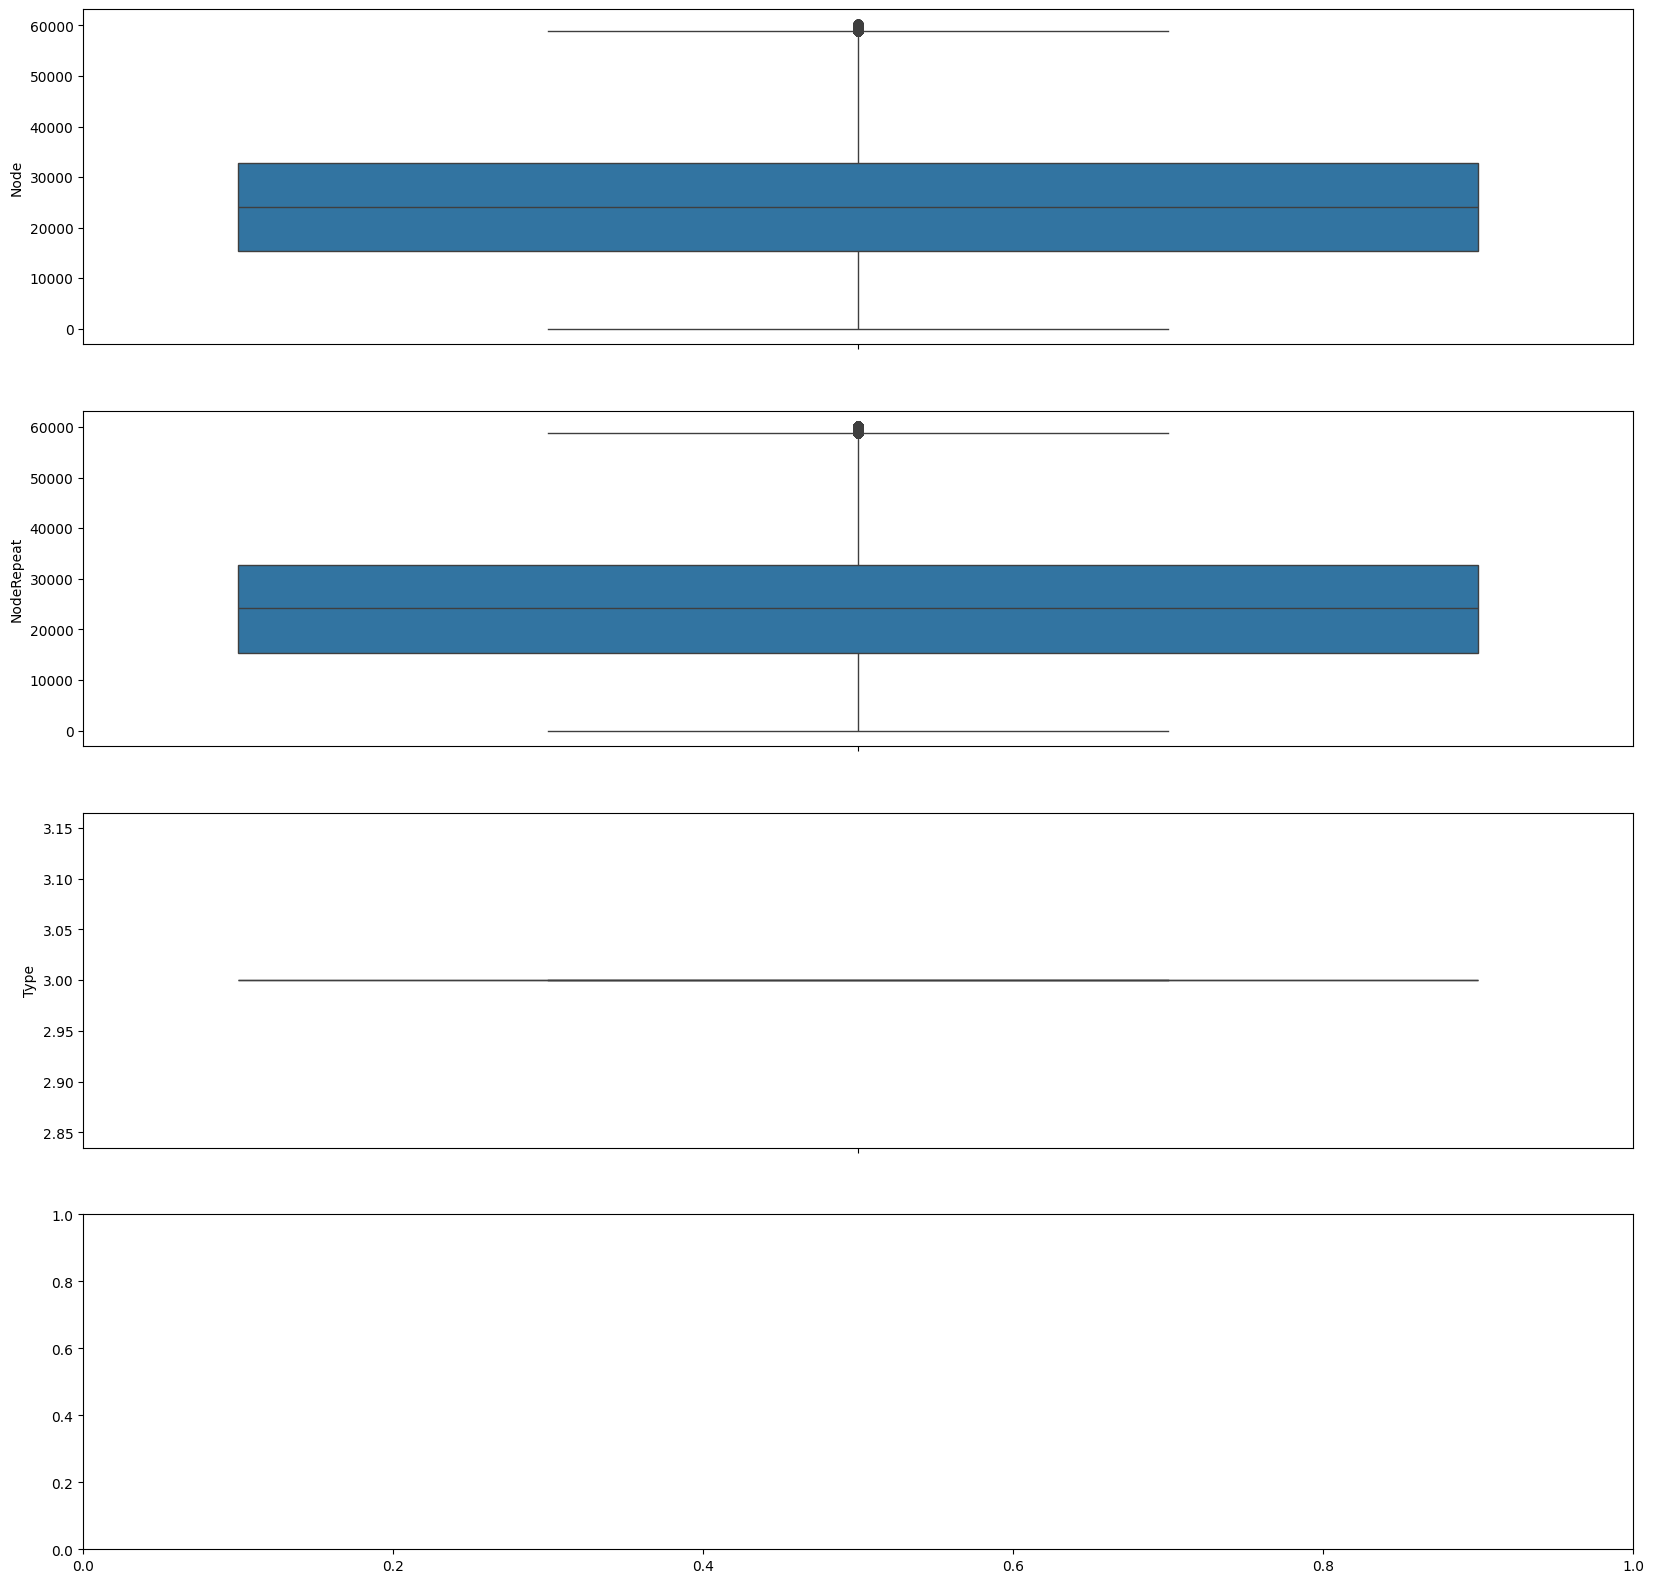

In [27]:
## Visualiser le boxplot après le traitement des valeurs aberrantes

fig, axs = plt.subplots(4, 1, figsize=(20, 20))
plt1 = sns.boxplot(dataset_ready['Node'], ax=axs[0])
plt1 = sns.boxplot(dataset_ready['NodeRepeat'], ax=axs[1])
plt1 = sns.boxplot(dataset_ready['Type'], ax=axs[2])

plt.show()

# **Distribution des variables discrètes**

In [28]:
# Obtenir la liste des variables continues
num_data = [cname for cname in dataset_ready.columns if dataset_ready[cname].dtypes in ['float64']]
num_data

['Node', 'NodeRepeat', 'Type']

In [29]:
# Obtenir la liste des variables discrètes et continues
cat_cols = dataset_ready._get_numeric_data().columns
cat_cols

Index(['LineId', 'Label', 'Timestamp', 'Date', 'Node', 'Time', 'NodeRepeat',
       'Type', 'Component', 'Level', 'Content', 'EventId', 'EventTemplate',
       'ParameterList'],
      dtype='object')

In [30]:
# Séparer les variables discrètes et continues
cols = list(set(cat_cols) - set(num_data))
cols

['LineId',
 'Label',
 'Time',
 'ParameterList',
 'Date',
 'Component',
 'EventId',
 'EventTemplate',
 'Content',
 'Level',
 'Timestamp']

In [31]:
len(cols)

11

In [32]:
dataset_ready.head()

,LineId,Label,Timestamp,Date,Node,Time,NodeRepeat,Type,Component,Level,Content,EventId,EventTemplate,ParameterList
0,1,0,1117838570,0,2739.0,0,2742.0,3.0,7,4,352408,432,1427,355694
1,2,0,1117838570,0,2739.0,1,2742.0,3.0,7,4,352408,432,1427,355694
2,3,0,1117838570,0,2739.0,2,2742.0,3.0,7,4,352408,432,1427,355694
3,4,0,1117838570,0,2739.0,3,2742.0,3.0,7,4,352408,432,1427,355694
4,5,0,1117838570,0,2739.0,4,2742.0,3.0,7,4,352408,432,1427,355694


In [ ]:
fig, ax = plt.subplots(nrows=15, ncols=1, figsize=(15, 30))

cols_ = ["EventTemplate",
 "Date",
 'Time',
 'LineId',
 'Label',
 "Level",
 "Component",
 'EventId',
 'Content',
  "ParameterList",
 'Timestamp']


for ind, col in enumerate(cols_):
   sns.countplot(x=col, data=dataset_ready, ax=ax[ind])

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x78b911ffe4d0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x78b911ffd1b0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Analysons l'impact de chacune des variables ci-dessus sur la variable cible

fig, ax = plt.subplots(2, 3, figsize=(40, 30))
sns.countplot(x='EventTemplate', hue='Label', data=dataset_ready, ax=ax[0][0])
sns.countplot(x='Date', hue='Label', data=dataset_ready, ax=ax[0][1])
sns.countplot(x='Time', hue='Label', data=dataset_ready, ax=ax[0][2])
sns.countplot(x='LineId', hue='Label', data=dataset_ready, ax=ax[1][0])
sns.countplot(x='Level', hue='Label', data=dataset_ready, ax=ax[1][1])
sns.countplot(x='Component', hue='Label', data=dataset_ready, ax=ax[1][2])
sns.countplot(x='EventId', hue='Label', data=dataset_ready, ax=ax[1][0])
sns.countplot(x='Content', hue='Label', data=dataset_ready, ax=ax[1][1])
sns.countplot(x='ParameterList', hue='Label', data=dataset_ready, ax=ax[1][2])

plt.show()

# **Prétraitement des données**

Sélection des caractéristiques en utilisant le test du chi-carré

Étant donné que nous avons 9 données discrètes (catégorielles), nous devons effectuer des tests d'hypothèse pour comprendre s'il existe une relation entre les variables dépendantes et indépendantes . Ensuite, nous pourrons analyser le type de relation à l'aide de graphiques. Faisons un test du chi-carré pour comprendre la relation entre la variable cible et les variables indépendantes.

Étape 1 : Sélection des caractéristiques significatives avec le Chi-carré Le test du Chi-carré a été utilisé pour évaluer l'importance de chaque caractéristique par rapport à la variable cible (y). Les caractéristiques avec des p-values inférieures à 0.05 ont été considérées comme significatives.

Étape 2 : Identification des caractéristiques fortement corrélées Une matrice de corrélation a été calculée pour les caractéristiques significatives sélectionnées. Les caractéristiques fortement corrélées ont été identifiées.

In [33]:
from sklearn.feature_selection import chi2

# Définir les caractéristiques catégorielles
categorical_features = ['EventTemplate',
 'Date',
 'Time',
 'LineId',
 'Level',
 'Component',
 'EventId',
 'Content',
 'ParameterList',
 'Timestamp']

# Séparer le jeu de données en variables d'entrée et variable cible
X = dataset_ready[categorical_features]
y = dataset_ready['Label']

# Appliquer le test du Chi-carré
f_score, p_values = chi2(X, y)

# Convertir les p-values en une série et trier
p_value_series = pd.Series(p_values, index=X.columns).sort_values(ascending=True)
print(p_value_series)

# Sélectionner les caractéristiques significatives
significance_level = 0.05
significant_features = p_value_series[p_value_series <= significance_level].index.tolist()
print("Caractéristiques significatives basées sur le test du Chi-carré :")
print(significant_features)

# Supprimer les caractéristiques non significatives de data parmi les categorical_features
data = dataset_ready.drop(columns=[col for col in categorical_features if col not in significant_features])

# Calculer la matrice de corrélation pour les caractéristiques significatives parmi les categorical_features
corr_matrix = dataset_ready[significant_features].corr().abs()

# Sélection des paires de caractéristiques fortement corrélées
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Affichage des caractéristiques à supprimer en raison d'une forte corrélation
print("Caractéristiques à supprimer en raison d'une forte corrélation :")
print(to_drop)

# Suppression des caractéristiques fortement corrélées dans data parmi les categorical_features
dataset_ready = dataset_ready.drop(columns=to_drop)
print("Caractéristiques finales après suppression des corrélations élevées :")
print(dataset_ready.columns)

# Affichage des premières lignes du DataFrame final
dataset_ready.head()

EventTemplate    0.0
Date             0.0
Time             0.0
LineId           0.0
Level            0.0
Component        0.0
EventId          0.0
Content          0.0
ParameterList    0.0
Timestamp        0.0
dtype: float64
Caractéristiques significatives basées sur le test du Chi-carré :
['EventTemplate', 'Date', 'Time', 'LineId', 'Level', 'Component', 'EventId', 'Content', 'ParameterList', 'Timestamp']
Caractéristiques à supprimer en raison d'une forte corrélation :
['Time', 'LineId', 'Content', 'Timestamp']
Caractéristiques finales après suppression des corrélations élevées :
Index(['Label', 'Date', 'Node', 'NodeRepeat', 'Type', 'Component', 'Level',
       'EventId', 'EventTemplate', 'ParameterList'],
      dtype='object')


,Label,Date,Node,NodeRepeat,Type,Component,Level,EventId,EventTemplate,ParameterList
0,0,0,2739.0,2742.0,3.0,7,4,432,1427,355694
1,0,0,2739.0,2742.0,3.0,7,4,432,1427,355694
2,0,0,2739.0,2742.0,3.0,7,4,432,1427,355694
3,0,0,2739.0,2742.0,3.0,7,4,432,1427,355694
4,0,0,2739.0,2742.0,3.0,7,4,432,1427,355694


In [34]:
# Enlever les caractéristiques continue qui ont une forte corrélation

dataset_ready.drop(['Node', 'NodeRepeat'], axis = 1, inplace = True)
dataset_ready.head()

,Label,Date,Type,Component,Level,EventId,EventTemplate,ParameterList
0,0,0,3.0,7,4,432,1427,355694
1,0,0,3.0,7,4,432,1427,355694
2,0,0,3.0,7,4,432,1427,355694
3,0,0,3.0,7,4,432,1427,355694
4,0,0,3.0,7,4,432,1427,355694


In [35]:
print(dataset_ready[["Label", "EventId"]].isnull().sum())


Label      0
EventId    0
dtype: int64


In [36]:
dataset_sample = dataset_ready.sample(n=1000)  # Exemple avec 1000 lignes


In [37]:
import pandas as pd
import numpy as np

# Optimiser l'utilisation de la mémoire
dataset_sample['Label'] = dataset_sample['Label'].astype('int8')
dataset_sample['EventId'] = dataset_sample['EventId'].astype('int32')

# Séparer les colonnes 'Label' et 'EventId'
dataset_event = dataset_sample[['Label', 'EventId']]

# Créer une colonne 'Event' combinant les colonnes d'événements
dataset_event['Event'] = dataset_event.apply(lambda row: f"E{row['EventId']}", axis=1)

# Pivot du DataFrame pour obtenir la matrice d'événements
event_matrix = dataset_event.pivot_table(index=np.arange(len(dataset_event)), columns='Event', values='Label', fill_value=0)

# Afficher la matrice d'événements
print(event_matrix)


Event  E1021  E1026  E1079  E110  E1117  E1127  E1141  E1177  E1188  E1254  \
0          0      0      0     0      0      0      0      0      0      0   
1          0      0      0     0      0      0      0      0      0      0   
2          0      0      0     0      0      0      0      0      0      0   
3          0      0      0     0      0      0      0      0      0      0   
4          0      0      0     0      0      0      0      0      0      0   
..       ...    ...    ...   ...    ...    ...    ...    ...    ...    ...   
995        0      0      0     0      0      0      0      0      0      0   
996        0      0      0     0      0      0      0      0      0      0   
997        0      0      0     0      0      0      0      0      0      0   
998        0      0      0     0      0      0      0      0      0      0   
999        0      0      0     0      0      0      0      0      0      0   

Event  ...  E816  E829  E847  E86  E887  E89  E895  E940  E972 

<ipython-input-37-e5ff75e3a072>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_event['Event'] = dataset_event.apply(lambda row: f"E{row['EventId']}", axis=1)


In [38]:
event_matrix.head()

Event,E1021,E1026,E1079,E110,E1117,E1127,E1141,E1177,E1188,E1254,...,E816,E829,E847,E86,E887,E89,E895,E940,E972,E977
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assurer que les colonnes et les index sont correctement formatés
# event_matrix.columns = event_matrix.columns.astype(str)
# event_matrix.index = event_matrix.index.astype(int)

# Séparer les caractéristiques (features) et les labels (target)
X = dataset_ready.drop('Label', axis=1)
y = dataset_ready['Label']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner un modèle de machine learning (RandomForestClassifier)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prédire les labels sur l'ensemble de test
y_pred = clf.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.9999961661910187
Precision: 0.9999900719781584
Recall: 0.9999602890953856
F1-score: 0.9999751803150114


**Diviser et équilibrer le jeu de données**

In [ ]:
dataset_ready.shape

(4347284, 8)

In [ ]:
X = dataset_ready.drop('Label', axis = 1)
y = dataset_ready['Label']

In [ ]:
# Équilibrer les données en utilisant SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=23)
X_sm, y_sm = sm.fit_resample(X, y)

**Gestion des données catégorielles**

# **Partie 4. Construction des Models et entrainement des models**